In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import os
import numpy as np
from scipy.io import loadmat, savemat
from scipy.signal import savgol_filter, butter, filtfilt, wiener
from statsmodels.nonparametric.smoothers_lowess import lowess as sm_lowess
from tsmoothie.smoother import *

import torch
from torch import optim, nn, utils, Tensor
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

from skimage.util import img_as_float
from sklearn.feature_extraction.image import extract_patches_2d, reconstruct_from_patches_2d
from sklearn.decomposition import MiniBatchDictionaryLearning
from ksvd import ApproximateKSVD
from spmimage.decomposition import KSVD, generate_dct_dictionary, generate_dct_dict

import sys; sys.path.insert(0, "../")
from misc import yaml_load
from savgol import *
from savitzky_golay_werrors import savgol_filter_werror

def l21shrink(epsilon, x):
    output = x.copy()
    norm = np.linalg.norm(x, ord=2, axis=0)
    for i in range(x.shape[1]):
        if norm[i] > epsilon:
            for j in range(x.shape[0]):
                output[j,i] = x[j,i] - epsilon * x[j,i] / norm[i]
        else:
            output[:,i] = 0.
    return output

main_seed = 0

import pathlib
def add_patchsize_signature(file_path, ps):
    sig = str(ps[0])+'x'+str(ps[1])
    pl = pathlib.Path(file_path)
    ext = pl.name.split('.')[-1]
    newname = pl.name.split('.')[0]+'_'+sig+'.'+ext
    return os.path.join(str(pl.parent.absolute()), newname)

def vis(rec):
    global x, t
    plt.contourf(*np.meshgrid(x, t), rec, levels=10)
    plt.colorbar()
    plt.show()

In [2]:
data = loadmat('../Datasets/KdV_sine_rep_big.mat')
u = (data['usol']).real
x = data['x'][0]
t = data['t'][0]
print("Domain shape:", u.shape)
dt = t[1]-t[0]
dx = x[1]-x[0]
X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T

Domain shape: (512, 501)


In [3]:
np.random.seed(0)
noise_lv = 180
un = u + 0.01*abs(noise_lv)*u.std()*np.random.randn(*u.shape)
((un-u)**2).mean()

1.6146344215597004

In [4]:
div = 20; axis = 1 # div = 10, 15, 20*
patch_size = (int(u.shape[0]//div), int(u.shape[1]//div))
avg_patch_size = (patch_size[0]+patch_size[1])//2
patch_size = (avg_patch_size, avg_patch_size)
print(patch_size)

un_img = img_as_float(un)
patches = extract_patches_2d(un_img, patch_size)

signals = patches.reshape(patches.shape[0], -1)
mean = np.mean(signals, axis=axis)
mean = mean[:, np.newaxis] if axis > 0 else mean
std = np.std(signals, axis=axis)
std = std[:, np.newaxis] if axis > 0 else mean
# signals = (signals-mean)/std
signals = signals-mean

(25, 25)


In [5]:
np.random.seed(main_seed)
# 64, 50, 40, 32, 16, 8 (64 was not so good | max should be 40?)
n_components = 32; alpha = 1; batch_size = 3
transform_n_nonzero_coefs = None # 1
mode = 'dctksvd_reg' # ksvd, dictionary_learning, spm_ksvd, spm_dctksvd, ksvd_reg
# n_components = fconfig["n_components"]

In [6]:
file_name = f"/Users/pongpisit/Desktop/research/ompbox10/KdV_sine_rep_noise{noise_lv}_sig.mat"
if patch_size[0] == patch_size[1]: file_name = add_patchsize_signature(file_name, patch_size)
mdict = {'sig':signals, 'D0':generate_dct_dict(n_components, (patch_size[0], patch_size[1])).T}
print(file_name)
# savemat(file_name, mdict)

/Users/pongpisit/Desktop/research/ompbox10/KdV_sine_rep_noise180_sig_25x25.mat


## Load results from MATLAB

In [7]:
ksvd_reg_data = loadmat(f"dctksvdV2_reg_out_noise{noise_lv}_25x25.mat")
Df = ksvd_reg_data['Df'].T
Xf = ksvd_reg_data['Xf'].T
omp_sc = ksvd_reg_data['sc']

In [8]:
reduced_un = omp_sc.T.dot(Df)+mean
reduced_un = reconstruct_from_patches_2d(reduced_un.reshape(patches.shape), un_img.shape)
reduced_un = np.array(reduced_un).astype(np.float32)
# np.save("./denoised_files/KdV_rep_sine_noise30_reduced_dctV2ksvdreg_25x25.npy", denoised)
((reduced_un-u)**2).mean() # 0.0007903031547856957

0.013446637221694726

In [9]:
# np.save(f"./denoised_files/KdV_rep_sine_noise{noise_lv}_reduced_dctV2ksvdreg_25x25", 
#         reduced_un)

## DySMHO

In [9]:
dysmho = DySMHO(un.T, div=10)
denoised = dysmho.smooth(window_size=3).T # 1(0.00641), 3(0.00635), 5(0.00664)
# np.save("./denoised_files/KdV_rep_sine_noise30_reduced_dysmho_25x25.npy", denoised)
((denoised-u)**2).mean(), dysmho.best_window_size

Max windown size: 52


--------------------------- Smoothing data ---------------------------


Prev STD: 0.06460 - New STD: 0.01085 - Percent change: -83.21045
Prev STD: 0.01085 - New STD: 0.00762 - Percent change: -29.74144
Prev STD: 0.00762 - New STD: 0.00674 - Percent change: -11.53197
Prev STD: 0.00674 - New STD: 0.00635 - Percent change: -5.85147
Smoothing window size: 33 



(0.003138643255286905, 33)

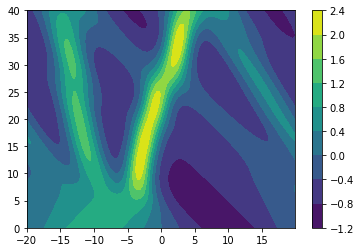

In [10]:
vis(u.T)

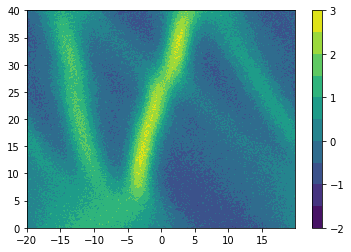

In [11]:
vis(un.T)

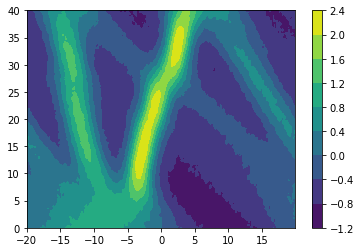

In [12]:
vis(reduced_un.T)